In [97]:
import os
import pickle
import sncosmo
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

In [98]:
sns.set_context('talk')
sns.set_style('ticks')

In [99]:
lcs = pickle.load(open('data/des_lcs.pkl', 'rb'))

In [100]:
sn_id = np.random.choice(list(lcs.keys()))
lc = lcs[sn_id]

In [101]:
salt = sncosmo.Model(source='salt2',
                     effects=[sncosmo.CCM89Dust()],
                     effect_names=['mw'],
                     effect_frames=['obs'])

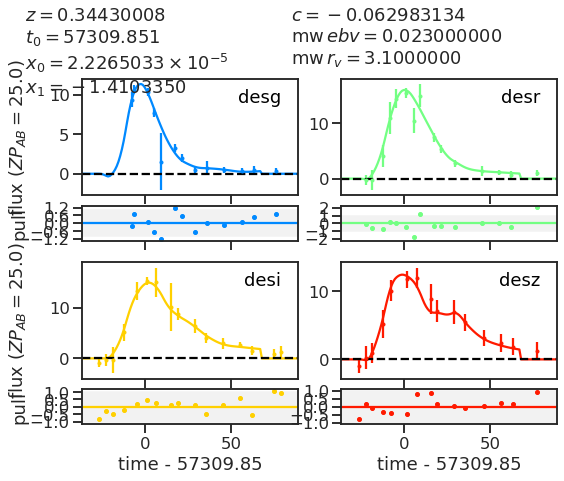

In [102]:
salt.set(z=lc.meta['z'], t0=lc.meta['t0'], x0=1e-7, x1=0, c=0, mwebv=lc.meta['mwebv'])
bounds = {'z': (lc.meta['z']-1e-4, lc.meta['z']+1e-4)}
result, model = sncosmo.fit_lc(lc, salt, vparam_names=['z', 't0', 'x0', 'x1', 'c'], bounds=bounds)
sncosmo.plot_lc(lc, model);

In [103]:
def calc_mb(**param_dict):
    """Calculates the apparent magnitude in the B-band based on the 
    SALT2 parameters in the param_dict"""
    model = sncosmo.Model(source='salt2',
                          effects=[sncosmo.CCM89Dust()],
                          effect_names=['mw'],
                          effect_frames=['obs'])
    model.set(**param_dict)
    try:
        mb = model.bandmag(band='bessellb', time=param_dict['t0'], magsys='ab')
    except:
        mb = np.nan
    return mb

In [104]:
calc_mb(**dict(zip(result['param_names'], model.parameters)))

22.950334253945908

In [105]:
DES_DATA_DIR = '/home/samdixon/DESSN/PublicDataRelease/02-DATA_PHOTOMETRY/DES-SN3YR_DES/'
def read_des_zp(sn_id):
    fname = 'des_{}.dat'.format(sn_id)
    path = os.path.join(DES_DATA_DIR, fname)
    meta, obs_list = sncosmo.read_snana_ascii(path, default_tablename='OBS')
    name = fname.split('_')[-1].split('.')[0]
    obs_list['OBS'].meta = meta
    lc = obs_list['OBS']
    lc['MJD'].name = 'time'
    lc['BAND'].name = 'band'
    lc['FLUXCAL'].name = 'flux'
    lc['FLUXCALERR'].name = 'flux_err'
    lc['zp'] = [27.5 for _ in lc]
    lc['zpsys'] = ['ab' for _ in lc]
    lc['band'] = ['des'+band_name for band_name in lc['band']]
    lc.meta = {'name': name,
               'survey': 'des',
               'z': lc.meta['REDSHIFT_FINAL'],
               'mwebv': lc.meta['MWEBV'],
               't0': lc.meta['PEAKMJD']}
    return lc

In [106]:
sn_id = np.random.choice(list(lcs.keys()))
zp_lc = read_des_zp(sn_id)

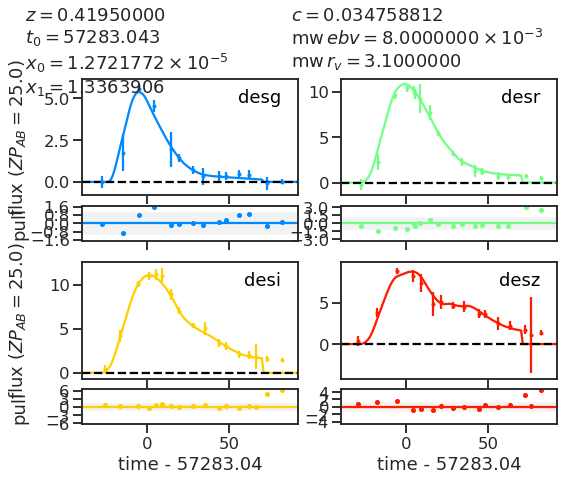

In [107]:
salt.set(z=zp_lc.meta['z'], t0=zp_lc.meta['t0'], x0=1e-7, x1=0, c=0, mwebv=zp_lc.meta['mwebv'])
bounds = {'z': (zp_lc.meta['z']-1e-4, zp_lc.meta['z']+1e-4),
          'x0': (0, 1),
          'x1': (-50, 50),
          'c': (-50, 50)}
result, model = sncosmo.fit_lc(zp_lc, salt, vparam_names=['z', 't0', 'x0', 'x1', 'c'], bounds=bounds)
sncosmo.plot_lc(zp_lc, model);

In [108]:
calc_mb(**dict(zip(model.param_names, model.parameters)))

23.88128708277716

In [109]:
fits_path = '/home/samdixon/sncosmo_lc_fits/collected_lc_fit_results.csv'
all_data = pd.read_csv(fits_path, index_col=0)
all_data = all_data[all_data.survey.str.lower().isin(['csp', 'foundation', 'des', 'snls', 'sdss', 'ps1'])]

In [110]:
salt_cuts = np.abs(all_data.x1) < 3
salt_cuts &= np.abs(all_data.c) < 0.3
salt_cuts &= all_data.x1_err < 1
salt_cuts &= all_data.c_err < 0.1
all_data = all_data[salt_cuts]

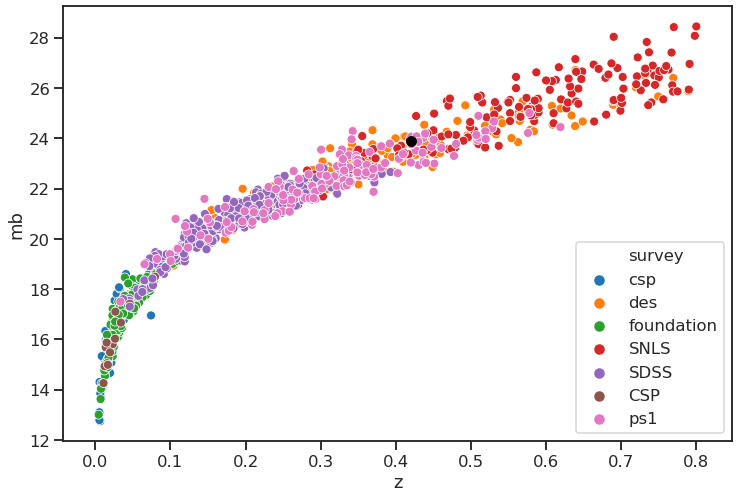

In [111]:
plt.figure(figsize=(12, 8))
sns.scatterplot('z', 'mb', hue='survey', data=all_data)
plt.scatter(zp_lc.meta['z'], calc_mb(**dict(zip(model.param_names, model.parameters))), c='k')
plt.scatter(all_data.loc[sn_id].z, all_data.loc[sn_id].mb, c='k')

100%|██████████| 177/177 [00:48<00:00,  3.68it/s]


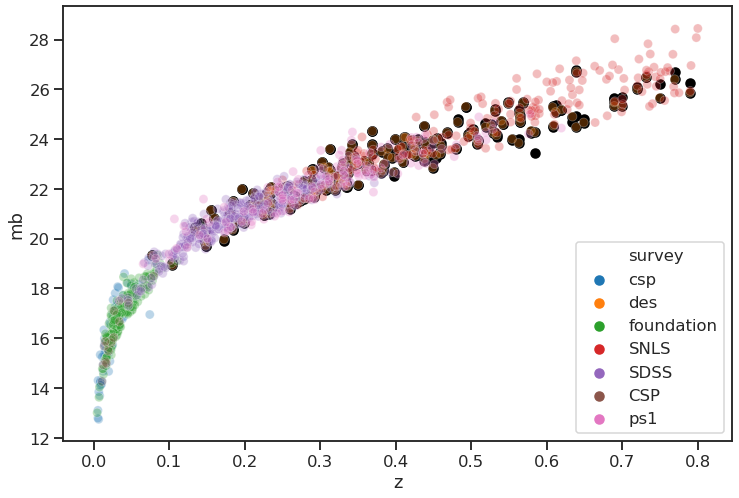

In [112]:
plt.figure(figsize=(12, 8))
for sn_id in tqdm(all_data[all_data.survey=='des'].index):
    zp_lc = read_des_zp(sn_id)
    salt.set(z=zp_lc.meta['z'], t0=zp_lc.meta['t0'], x0=1e-7, x1=0, c=0, mwebv=zp_lc.meta['mwebv'])
    bounds = {'z': (zp_lc.meta['z']-1e-4, zp_lc.meta['z']+1e-4),
              'x0': (0, 1),
              'x1': (-50, 50),
              'c': (-50, 50)}
    result, model = sncosmo.fit_lc(zp_lc, salt, vparam_names=['z', 't0', 'x0', 'x1', 'c'], bounds=bounds)
    plt.scatter(zp_lc.meta['z'], calc_mb(**dict(zip(model.param_names, model.parameters))), c='k')
    plt.scatter(all_data.loc[sn_id].z, all_data.loc[sn_id].mb, c='k')
sns.scatterplot('z', 'mb', hue='survey', data=all_data, alpha=0.3)

# JLA

In [121]:
jla = pickle.load(open('data/jla_lcs.pkl', 'rb'))

In [122]:
sn_id = '05D1er'
lc = jla[sn_id]

In [123]:
lc['band']

"AggregateBandpass: 6 components, prefactor=1.0, range=(3990.0, 5800.0), name='megacampsf::g at 12.945166'"
"AggregateBandpass: 6 components, prefactor=1.0, range=(3990.0, 5800.0), name='megacampsf::g at 12.945166'"
"AggregateBandpass: 6 components, prefactor=1.0, range=(3990.0, 5800.0), name='megacampsf::g at 12.945166'"
"AggregateBandpass: 6 components, prefactor=1.0, range=(3990.0, 5800.0), name='megacampsf::g at 12.945166'"
"AggregateBandpass: 6 components, prefactor=1.0, range=(3990.0, 5800.0), name='megacampsf::g at 12.945166'"
"AggregateBandpass: 6 components, prefactor=1.0, range=(3990.0, 5800.0), name='megacampsf::g at 12.945166'"
"AggregateBandpass: 6 components, prefactor=1.0, range=(3990.0, 5800.0), name='megacampsf::g at 12.945166'"
"AggregateBandpass: 6 components, prefactor=1.0, range=(3990.0, 5800.0), name='megacampsf::g at 12.945166'"
"AggregateBandpass: 6 components, prefactor=1.0, range=(3990.0, 5800.0), name='megacampsf::g at 12.945166'"
"AggregateBandpass: 6 components, prefactor=1.0, range=(3990.0, 5800.0), name='megacampsf::g at 12.945166'"
"AggregateBandpass: 6 components, prefactor=1.0, range=(3990.0, 5800.0), name='megacampsf::g at 12.945166'"


In [115]:
sncosmo.plot_lc(lc)

Exception: 'megacampsf::g at 12.048380' not in registry. Registered names: 'f140w', 'besselli', 'f360m', 'f115w', 'f555w', 'nicf160w', 'sdssg', 'swope2::b', 'f775w', 'f140m', 'f444w', 'f430m', 'sdss::u', 'swope2::v', 'f300m', 'uvf814w', 'sdss::g', 'acswf::f850lp', '4shooter2::us', 'standard::r', 'sdssr', '4shooter2::b', 'standard::v', 'f770w', 'sdssu', 'csphd', 'f210m', 'uvf850lp', 'cspk', '4shooter2::r', 'cspv3014', 'f125w', 'f153m', 'f277w', 'f1550c', 'lsstz', 'f127m', 'f090w', 'f110w', 'desg', 'swope2::g', 'swope2::v1', 'f275w', 'swope2::v2', 'lsstu', 'f410m', 'swope2::u', 'desr', 'keplercam::us', 'f438w', 'swope2::y', 'cspi', 'nicmos2::f160w', 'f300x', 'acswf::f606w', 'lsstr', 'bessellb', 'f850lp', 'standard::u', 'f350lp', 'f200w', 'uvf555w', 'keplercam::v', 'f435w', 'cspu', 'f763m', 'f070w', 'desz', 'nicmos2::f110w', 'cspv3009', 'f1130w', 'cspv9844', 'f105w', 'uvf475w', 'f160w', 'swope2::r', 'cspg', 'f1280w', 'f182m', 'f1800w', 'bessellv', 'f1500w', 'swope2::h', 'f460m', 'keplercam::i', 'f250m', 'uvf606w', 'f335m', 'f475w', 'uvf775w', 'f560w', 'f2100w', 'desi', 'cspyd', 'cspjd', 'sdss::z', '4shooter2::v', 'f139m', 'f1065c', 'f2300c', 'standard::i', 'f2550w', 'f606w', '4shooter2::i', 'f218w', 'f1140c', 'f150w', 'swope2::i', 'cspr', 'f336w', 'lsstg', 'f356w', 'bessellr', 'f390w', 'desy', 'cspb', 'cspjs', 'keplercam::b', 'bessellux', 'keplercam::r', 'cspys', 'sdssi', 'f098m', 'lssty', 'lssti', 'f845m', 'acswf::f775w', 'f625w', 'f689m', 'f480m', 'sdss::r', 'swope2::j', 'f225w', 'f162m', 'uvf625w', 'standard::b', 'kepler', 'csphs', 'sdssz', 'f1000w', 'nicf110w', 'sdss::i'